## Solving a equation with PINNs using the neurodiffeq module



Documentation: https://neurodiffeq.readthedocs.io/en/latest/index.html

Let's consider the equation 

$$x^{\prime\prime}-\alpha x=0$$

where $\alpha$ is a parameter of the model. If we use a numerical integrator, we need to fix the value of $\alpha$ each time we integrate the equation. One important goal of the Neurodiffeq library is the bundle method, which allows solving the differential equation as a function of parameters. The analytical solution in this case is:

$$x(t,\alpha) = \frac{1}{2}e^{\sqrt{\alpha}t} + \frac{1}{2}e^{-\sqrt{\alpha}t}$$

And from this it follows that:

$$y(t,\alpha) = \sqrt{\alpha}\left(\frac{1}{2}e^{\sqrt{\alpha}t} - \frac{1}{2}e^{-\sqrt{\alpha}t}\right)$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from neurodiffeq.solvers import BundleSolver1D
from neurodiffeq.conditions import BundleIVP
from neurodiffeq import diff  
from neurodiffeq.generators import Generator1D
from neurodiffeq.networks import FCNN

After importing the libraries, we define the range of the independent variable, the bundle parameter and also the differential equation. Note that the syntax in this case is slightly different from Tutorial 1.

In [ ]:
'''Set the range of the independent variable:
'''
t_0 = 0
t_f = 1

'''Set the range of the bundle parameter
'''
alpha_0 = 1
alpha_f = 2

'''Define the differential equation with the bundle parameter
'''
def ODE(x, x_p, t, alpha):
    '''Here you define a residual for each differential equation in your system
       so if you want to change the equation to solve, you should modify the 
       res1 and res2. x, x_p, t & alpha are tensors that this function will receive
       during the training.
    '''    
    res1 = diff(x, t) - x_p
    res2 = diff(x_p, t) - alpha * x
    return [res1 , res2]

The next step is to define the initial conditions. In the bundle case the “BundleIVP” function is used instead of the “IVP” function. The bundle function also allows to include parameters in the initial condition. In our case this is not necessary since the initial condition does not depend on alpha.

In [3]:
x_0 = 1
y_0 = 0

conditions = [BundleIVP(t_0, x_0), BundleIVP(t_0, y_0)]

We can also define a custom loss using the residuals of the equation. If you want to change the loss for the training, you can implement the changes here. For example, if you want to give more importance to the training near the initial condition, you can multiply by an exponential factor of the type: $e^{-\omega(t-t_0)}$, where $\omega$ is a weight that you can choose.

In [4]:
def loss_example(res, x, t):
    loss = res ** 2
    return loss.mean()

Now we define the architecture of the networks. Here, we are using a NN with two internal layers with 32 neurons in each one. If you want, for example, three interal layers with 64 neurons you should put: hidden_units=(64,64,64,). Here we are using two inputs: (t, \alpha) and we set two networks (one for each equation).

In [6]:
nets = [FCNN(n_input_units=2,  hidden_units=(32,32,)) for _ in range(2)]

Define the optimizator for the trainig. Here we are using ADAM with a learning rate of 1e-3. If you want a slowly training you can use a lower lr. You can also modify another paramters checking the documentation of neurodiffeq.

In [7]:
adam = torch.optim.Adam(set([p for net in nets for p in net.parameters()]), lr=1e-3)

Define the training and the validation set. We need to define sets for the bundle parameter too.

In [8]:
batch_size = 32

tg_t = Generator1D(batch_size, t_min=t_0, t_max=t_f)
vg_t = Generator1D(batch_size, t_min=t_0, t_max=t_f)

tg_alpha = Generator1D(batch_size, t_min=alpha_0, t_max=alpha_f)
vg_alpha = Generator1D(batch_size, t_min=alpha_0, t_max=alpha_f)

train_gen = tg_t ^ tg_alpha 
valid_gen = vg_t ^ vg_alpha

No we define the solver of the NN. Here you will use all the definitions made before.

In [9]:
solver = BundleSolver1D(ode_system=ODE,
                        nets=nets,
                        conditions=conditions,
                        t_min=t_0, t_max=t_f,
                        theta_min=(alpha_0),
                        theta_max=(alpha_f),
                        eq_param_index=(0,),
                        optimizer=adam,
                        train_generator=train_gen,
                        valid_generator=valid_gen,
                        loss_fn=loss_example,
                        )

Finally, set the amount of iterations and start the training.

In [10]:
iterations = 5000
solver.fit(iterations)

Training Progress: 100%|██████████| 5000/5000 [00:49<00:00, 100.52it/s]


Now we can plot the loss function during the training and also save the networks.

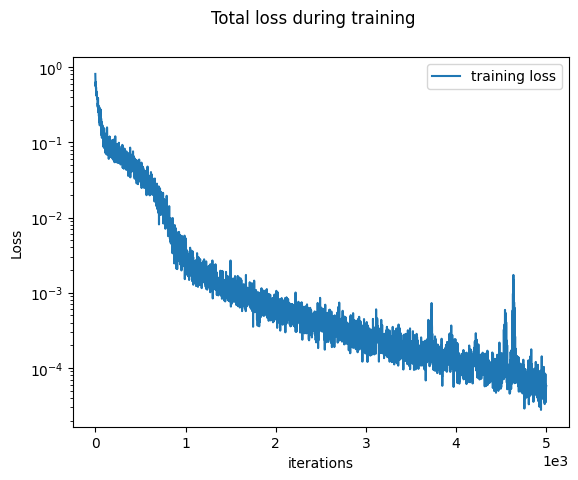

In [11]:
plt.figure()
loss = solver.metrics_history['train_loss']
plt.plot(loss, label='training loss')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0, 0))
plt.xlabel('iterations')
plt.ylabel('Loss')
plt.yscale('log')
plt.legend()
plt.suptitle('Total loss during training')
plt.savefig('loss_example_bundle.png')
plt.show()

torch.save(solver._get_internal_variables()['best_nets'], 'bundle_model.ph')

Now let's check the solution and compare it with the analytical solution. First for $x(t)$

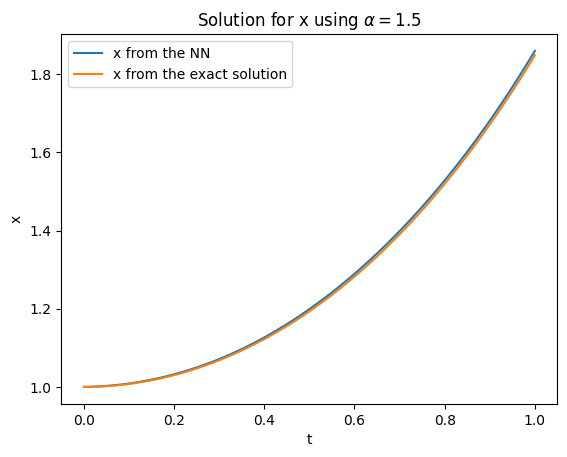

In [12]:
v_sol = solver.get_solution()
ts = np.linspace(t_0,t_f,1000)
alpha = 1.5
alphas = alpha * np.ones_like(ts)
x, y = v_sol(ts, alphas, to_numpy=True)

def exact_sol(t,a):
    return np.exp(np.sqrt(a)*t)/2 + np.exp(-np.sqrt(a)*t)/2

x_exact = exact_sol(ts,alpha)

plt.figure()
plt.plot(ts, x, label = 'x from the NN')
plt.plot(ts, x_exact, label = 'x from the exact solution')
plt.xlabel('t')
plt.ylabel('x')
plt.title(r'Solution for x using $\alpha = 1.5$')
plt.legend()
plt.show()

Now for $x^\prime(t)$

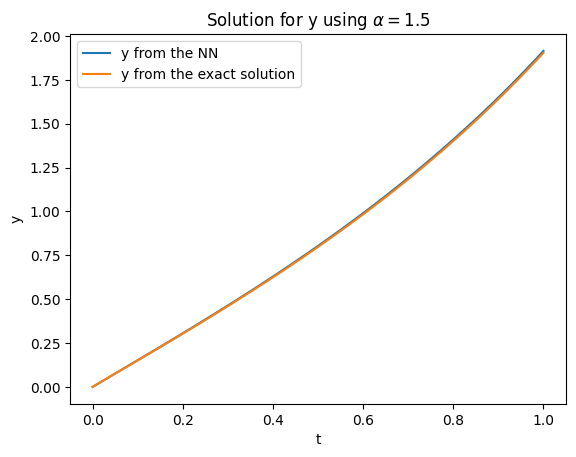

In [13]:
def exact_sol_p(t,a):
    return np.sqrt(a)*(np.exp(np.sqrt(a)*t)/2 - np.exp(-np.sqrt(a)*t)/2)

y_exact = exact_sol_p(ts,alpha)

plt.figure()
plt.plot(ts, y, label = 'y from the NN')
plt.plot(ts, y_exact, label = 'y from the exact solution')
plt.xlabel('t')
plt.ylabel('y')
plt.title(r'Solution for y using $\alpha = 1.5$')
plt.legend()
plt.show()

Finally, let's compute and plot the percentage difference between the exact and the NN solutions.

/tmp/ipykernel_8632/1185895528.py:2: RuntimeWarning: invalid value encountered in divide
  perc_err_y = 100 * np.abs(y - y_exact)/np.abs(y_exact)


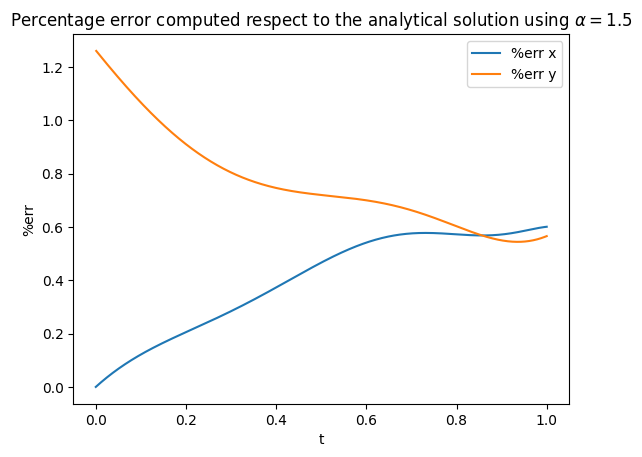

In [14]:
perc_err_x = 100 * np.abs(x - x_exact)/np.abs(x_exact)
perc_err_y = 100 * np.abs(y - y_exact)/np.abs(y_exact)

plt.figure()
plt.plot(ts, perc_err_x, label = '%err x')
plt.plot(ts, perc_err_y, label = '%err y')
plt.xlabel('t')
plt.ylabel('%err')
plt.title(r'Percentage error computed respect to the analytical solution using $\alpha = 1.5$')
plt.legend()
plt.show()

## Training moment!!

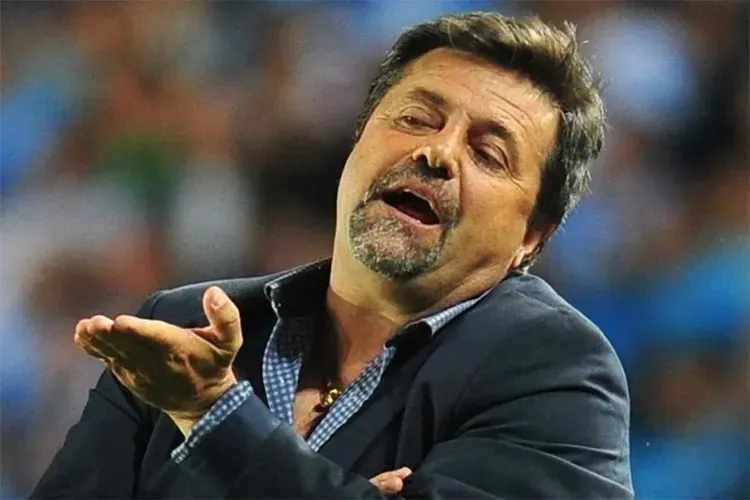

## Exercise!

Consider the equation

$$x^{\prime\prime}(t)+\alpha x^{\prime}(t)-\beta x(t)=0$$

with initial conditions: $x(0)=1$, $x^\prime(0)=0$, and $t \in [0,1]$.

**a)** Solve the equation using the `neurodiffeq` module for the values $\alpha = \beta = 1$. Note: you CAN'T fix $\beta=0$ and use the bundle method only for $\alpha$.

**b)** Compute the percentage difference between the PINN-based solution and the analytical one in the range $[0,1]$. Now do the same for the range $[-1,2]$. 

**Hint:** The analytical solution for these parameter values is:

$$x(t) = \frac{1}{2\sqrt{5}}\left((1+\sqrt{5})e^{(-1+\sqrt{5})t/2}+(-1+\sqrt{5})e^{-(1+\sqrt{5})t/2}\right)$$

**c)** Achieve an accuracy such that the percentage error is less than 1% for all values of t (if your solution is not so good, go back to training!).

**d)** Compute and plot the residuals and try to interpretate them.

Send your solution to gomezlucajavier@gmail.com.

**Note:** You can solve this exercise with or without using the *bundle method*. If you choose to use the bundle method, be careful with the number of inputs to the networks, and also with the definition of `eq_param_index` in the solver. While the bundle method might make it easier to follow the structure of the code, it may also lead to longer training times.


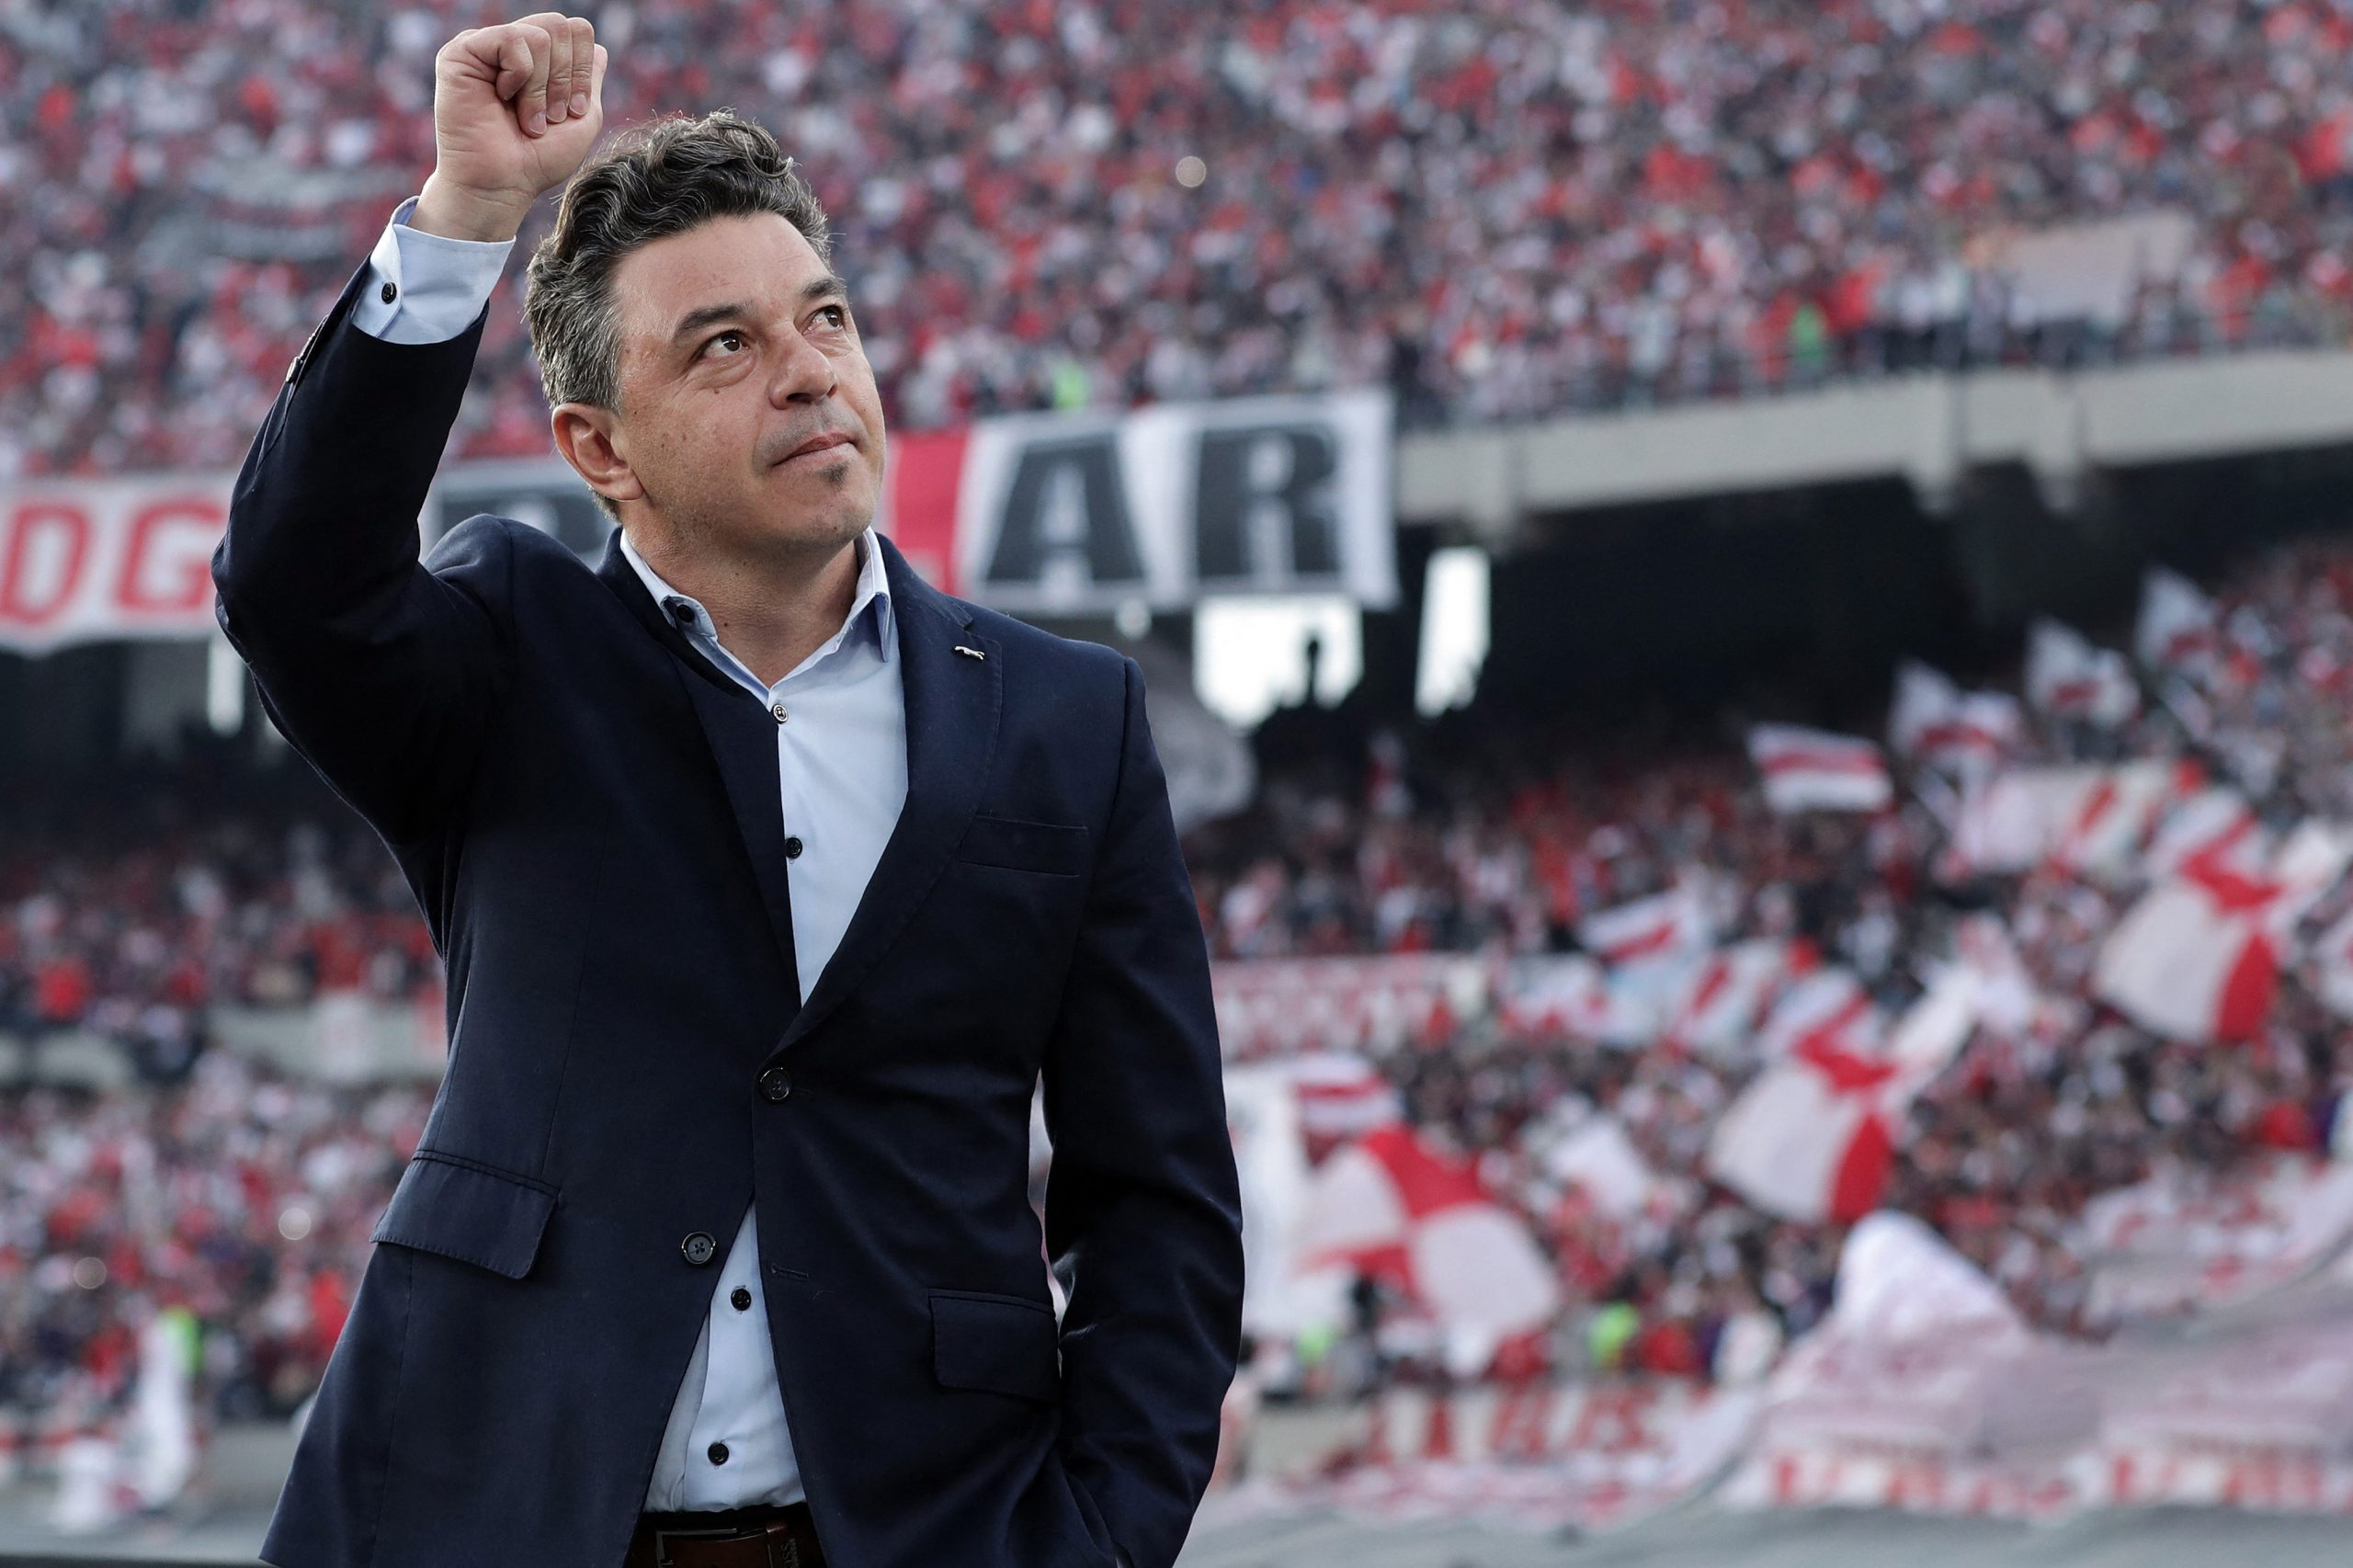